# <center> Trabajo Practico 2 </center>
### <center> Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré


# Importaciones

## Algunas instalaciones

A ejecutar solo si no dispone de los paquetes necesarios

In [1]:
!pip install stop_words

In [2]:
!pip install es_core_news_sm

## Librerias

In [1]:
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import stop_words
import tensorflow as tf

from tensorflow import keras

from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Dense, Dropout, Input, TextVectorization
from keras.metrics import F1Score
from keras.models import load_model
from keras.optimizers import Adadelta, Adam, RMSprop
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Conjuntos

In [2]:
# Cargar los datasets del Kaggle
conjunto_train = pd.read_csv('Datasets/train.csv')
conjunto_test = pd.read_csv('Datasets/test.csv')
sample_solution = pd.read_csv('Datasets/sample_solution.csv')

# StopWords que va a servir a lematizar
stop_words_es = stop_words.get_stop_words('es')

## Train_test_split

No se debe ejecutar de nuevo

In [5]:
# Dividir los conjuntos
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exportacion de esos nuevos conjuntos
X_train.to_csv('Datasets/X_train.csv')
X_test.to_csv('Datasets/X_test.csv')
y_train.to_csv('Datasets/y_train.csv')
y_test.to_csv('Datasets/y_test.csv')

## Lematizacion

No se debe ejecutar de nuevo

In [25]:
# Transformacion del conjunto test
test = conjunto_test.set_index('ID')
test.index.name = None
test = test['review_es']
test

60000    La mayor virtud de esta película es su existen...
60001    No soy un experto cinéfilo, pero pocas veces m...
60002    Si no eres un incondicional del humor estilo T...
60003    No sé qué está pasando, si la gente se deja ll...
60004    Pero cuando amanece,y me quedo solo,siento en ...
                               ...                        
68594    Buena no, lo siguiente. Por fin un film serio ...
68595    Me esperaba mucho, pero que mucho, más.Guión m...
68596    De mal cuerpo como sensación al finalizar, de ...
68597    Los que han añadido comentarios os lo han dich...
68598    Fui a ver esta película de cine con entusiasmo...
Name: review_es, Length: 8599, dtype: object

In [26]:
# Lematizacion
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

# Exportaciones
conjunto_test_processed = test.apply(preprocess_text)
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
conjunto_test_processed.to_csv('Datasets/conjunto_test_processed.csv')
X_train_processed.to_csv('Datasets/X_train_processed.csv')
X_test_processed.to_csv('Datasets/X_test_processed.csv')

# 1. Bayes Naïve

## Importaciones

In [3]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
conjunto_test_processed = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lematizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lematizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lematizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lematizacion y con hiperparametros afinados

In [4]:
best_configs = []

# Creacion de las diferentes combinaciones de hiperparametros
min_dfs = [1, 2, 3, 5, 8, 10, 12, 15]
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
configs = [{'min_df': min_df, 'ngram_range': ngram_range} for min_df in min_dfs for ngram_range in ngram_ranges]

# Model de referencia para encontrar la vectorizacion optimizada
nb_old_model = joblib.load('Modelos/bn_model_2024-06-12.joblib')

def test_config(config, X_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)

    # Aca tenemos problemas con ese parametro cuando cargamos el modelo, asi ponemos True cada vez
    if hasattr(nb_old_model, 'force_alpha') and nb_old_model.force_alpha not in [True, False]:
        nb_old_model.force_alpha = True
    
    score = cross_val_score(nb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

### Vect_1

In [5]:
best_score_1 = 0
best_config_1 = None

for config in configs:
    score = test_config(config, X_train, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 2, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_1 : 0.886926


### Vect_2

In [6]:
best_score_2 = 0
best_config_2 = None

for config in configs:
    score = test_config(config, X_train_processed, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.882998


### Vect_3

In [7]:
best_score_3 = 0
best_config_3 = None

for config in configs:
    score = test_config(config, X_train, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_3 : 0.878272


### Vect_4

In [8]:
best_score_4 = 0
best_config_4 = None

for config in configs:
    score = test_config(config, X_train_processed, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.874868


### Mejor Vect

In [9]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lematizacion", "Tipo de vectorizacion"])
best_configs_df

,Score,Config,Lematizacion,Tipo de vectorizacion
0,0.886926,"{'min_df': 2, 'ngram_range': (1, 3)}",False,TFIDF
1,0.882998,"{'min_df': 2, 'ngram_range': (1, 4)}",True,TFIDF
2,0.878272,"{'min_df': 2, 'ngram_range': (1, 4)}",False,Count
3,0.874868,"{'min_df': 2, 'ngram_range': (1, 4)}",True,Count


In [13]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lematizacion']
type_vect = best_configs_df.loc[best_index, 'Tipo de vectorizacion']

print(f"Score: {best_score} - Configuracion: {best_config} - Lematizacion: {bool_lemma} - Tipo: {type_vect}")

Score: 0.886926 - Configuracion: {'min_df': 2, 'ngram_range': (1, 3)} - Lematizacion: False - Tipo: TFIDF


In [14]:
if bool_lemma :
    # Si vamos a utilizar la lematizacion
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [15]:
# Los hiperparametros a probar
param_distributions = {
    'alpha': [0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0]
}

nb_model = MultinomialNB()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_distributions, cv=5, n_iter=20, scoring=f1_scorer)
random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

# Vamos a afinar el parametro elegido
best_params = random_search.best_params_
param_grid = {
    'alpha': [best_params['alpha'] - 0.05, best_params['alpha'] - 0.02, best_params['alpha'], best_params['alpha'] + 0.02, best_params['alpha'] + 0.05]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train_vect, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Mejores parametros (afinados): {best_params}')
print(f'Mejor F1 Score (afinados): {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parametros: {'alpha': 0.2}
Mejor F1 Score: 0.886841592387636
Mejores parametros (afinados): {'alpha': 0.22}
Mejor F1 Score (afinados): 0.8870333497774672


In [16]:
best_nb_model = grid_search.best_estimator_
best_nb_model.fit(X_train_vect, y_train)
y_pred = best_nb_model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8864
Precision: 0.8778315585672798
Recall: 0.8997817027187934
F1 Score: 0.8886711093688748


## Conjunto test

In [17]:
if bool_lemma:
    # Si utilizamos el conjunto con lematizacion
    conjunto_test = conjunto_test_processed.copy()
    X_conjunto_test = vect.transform(conjunto_test)
    
else :
    conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
    X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [18]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Bayes_Naïve_{current_date}.csv", index=False)

joblib.dump(best_nb_model, f'Modelos/bn_model_{current_date}.joblib')

['Modelos/bn_model_2024-06-25.joblib']

# 2. Random Forest

## Importaciones

In [70]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
conjunto_test_processed = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lematizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lematizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lematizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lematizacion y con hiperparametros afinados

In [71]:
best_configs = []

# Creacion de las diferentes combinaciones de hiperparametros
min_dfs = [1, 2, 3, 4, 5, 8, 10, 15]
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
configs = [{'min_df': min_df, 'ngram_range': ngram_range} for min_df in min_dfs for ngram_range in ngram_ranges]

# Model de referencia para encontrar la vectorizacion optimizada
rf_old_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(rf_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

# Funcion para guardar un sample de nuestros datasets
def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [72]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 1, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.817644


### Vect_2

In [73]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 3, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.812457


### Vect_3

In [74]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.762886


### Vect_4

In [75]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 5, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_4 : 0.770027


### Mejor Vect

In [76]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lematizacion", "Tipo de vectorizacion"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.817644,"{'min_df': 1, 'ngram_range': (1, 2)}",False,TFIDF
1,0.812457,"{'min_df': 3, 'ngram_range': (1, 4)}",True,TFIDF
2,0.762886,"{'min_df': 3, 'ngram_range': (1, 2)}",False,Count
3,0.770027,"{'min_df': 5, 'ngram_range': (1, 2)}",True,Count


In [77]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lematizacion']
type_vect = best_configs_df.loc[best_index, 'Tipo de vectorizacion']

print(f"Score: {best_score} - Configuracion: {best_config} - Lematizacion: {bool_lemma} - Tipo: {type_vect}")

0.817644 {'min_df': 1, 'ngram_range': (1, 2)} False TFIDF


In [78]:
if bool_lemma :
    # Si vamos a utilizar la lematizacion
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [79]:
# Los hiperparametros a probar
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [1, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15],
}

rf = RandomForestClassifier()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)
random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.p

Mejores parametros: {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 6, 'criterion': 'gini'}
Mejor F1 Score: 0.8238485580018311


In [80]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_vect, y_train)
y_pred = best_rf_model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

F1 Score: 0.822934573768834


In [81]:
# Exportaciones
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/rf_model_random_search_{current_date}.joblib')
joblib.dump(best_rf_model, f'Modelos/rf_model_{current_date}.joblib')

['Modelos/rf_model_2024-06-15.joblib']

## Conjunto test

In [82]:
if bool_lemma:
    # Si utilizamos el conjunto con lematizacion
    conjunto_test = conjunto_test_processed.copy()
    X_conjunto_test = vect.transform(conjunto_test)
    
else :
    conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
    X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_rf_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [83]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/RandomForest_{current_date}.csv", index=False)

# 3. XGBoost

## Importaciones

In [ ]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
conjunto_test_processed = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lematizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lematizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lematizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lematizacion y con hiperparametros afinados

In [ ]:
best_configs = []

# Creacion de las diferentes combinaciones de hiperparametros
min_dfs = [1, 2, 3, 4, 5, 8, 10, 15]
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
configs = [{'min_df': min_df, 'ngram_range': ngram_range} for min_df in min_dfs for ngram_range in ngram_ranges]

# Model de referencia para encontrar la vectorizacion optimizada
xgb_old_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(xgb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

# Funcion para guardar un sample de nuestros datasets
def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [ ]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 1, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.817644


### Vect_2

In [ ]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 3, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.812457


### Vect_3

In [ ]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.762886


### Vect_4

In [ ]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 5, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_4 : 0.770027


### Mejor Vect

In [ ]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lematizacion", "Tipo de vectorizacion"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.817644,"{'min_df': 1, 'ngram_range': (1, 2)}",False,TFIDF
1,0.812457,"{'min_df': 3, 'ngram_range': (1, 4)}",True,TFIDF
2,0.762886,"{'min_df': 3, 'ngram_range': (1, 2)}",False,Count
3,0.770027,"{'min_df': 5, 'ngram_range': (1, 2)}",True,Count


In [ ]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lematizacion']
type_vect = best_configs_df.loc[best_index, 'Tipo de vectorizacion']

print(f"Score: {best_score} - Configuracion: {best_config} - Lematizacion: {bool_lemma} - Tipo: {type_vect}")

0.817644 {'min_df': 1, 'ngram_range': (1, 2)} False TFIDF


In [ ]:
if bool_lemma :
    # Si vamos a utilizar la lematizacion
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [99]:
# Los hiperparametros a probar
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'early_stopping_rounds': [5, 10, 20]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

X_train_sampled, y_train_sampled = sample_df(X_train_vect, y_train)
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)
random_search.fit(X_train_sampled, y_train_sampled)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

In [102]:
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_vect, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect, y_test)])
y_pred = best_xgb_model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66850
[1]	validation_0-logloss:0.64941
[2]	validation_0-logloss:0.63408
[3]	validation_0-logloss:0.62248
[4]	validation_0-logloss:0.61195
[5]	validation_0-logloss:0.60315
[6]	validation_0-logloss:0.59491
[7]	validation_0-logloss:0.58795
[8]	validation_0-logloss:0.58050
[9]	validation_0-logloss:0.57405
[10]	validation_0-logloss:0.56877
[11]	validation_0-logloss:0.56365
[12]	validation_0-logloss:0.55903
[13]	validation_0-logloss:0.55369
[14]	validation_0-logloss:0.54970
[15]	validation_0-logloss:0.54526
[16]	validation_0-logloss:0.54161
[17]	validation_0-logloss:0.53768
[18]	validation_0-logloss:0.53415
[19]	validation_0-logloss:0.53087
[20]	validation_0-logloss:0.52747
[21]	validation_0-logloss:0.52417
[22]	validation_0-logloss:0.52152
[23]	validation_0-logloss:0.51892
[24]	validation_0-logloss:0.51591
[25]	validation_0-logloss:0.51338
[26]	validation_0-logloss:0.51078
[27]	validation_0-logloss:0.50809
[28]	validation_0-logloss:0.50572
[29]	validation_0-loglos

In [103]:
# Exportaciones
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/xgb_model_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model, f'Modelos/xgb_model_{current_date}.joblib')

['Modelos/xgb_model_2024-06-15.joblib']

## Conjunto test

In [104]:
if bool_lemma:
    # Si utilizamos el conjunto con lematizacion
    conjunto_test = conjunto_test_processed.copy()
    X_conjunto_test = vect.transform(conjunto_test)
    
else :
    conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
    X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_xgb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [105]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/XGBoost_{current_date}.csv", index=False)

# 4. Red Neuronal aplicando Keras y Tensor Flow

## Importaciones

In [3]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
conjunto_test_processed = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)['review_es']

## Si queremos aumentar los datos

Eso fue una tentativa no exitosa

In [15]:
# Funcion para eliminar algunas palabras en cada crítica y anadirlas en el conjunto inicial
def random_deletion(text, p):
    words = text.split()
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        print([random.choice(words)])
        return [random.choice(words)]
    return ' '.join(new_words)

X_train_augmented_random_deletion = X_train_processed.apply(lambda x: random_deletion(x, 0.3))
X_train_augmented_random_deletion.index = X_train_augmented_random_deletion.index + 40000
y_train_augmented_random_deletion = y_train.copy()
y_train_augmented_random_deletion.index = y_train_augmented_random_deletion.index + 40000

X_train_augmented = pd.concat([X_train_processed, X_train_augmented_random_deletion])
y_train_augmented = pd.concat([y_train, y_train_augmented_random_deletion])
X_train = X_train_augmented
y_train = y_train_augmented

## Eleccion del modelo

In [6]:
# Transformacion en lista
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

# Transformacion en array
X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

In [22]:
# Funcion para generar un modelo de red neuronal con hiperparametros selecionados
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5, max_tokens=10000, dropout_rate=0.5):
    
    # El optimizador selecionado
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    # Vectorizacion de los textos para utilizarlos
    vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=max_tokens)
    vectorizer.adapt(X_train_list)

    # Nuestro modelo
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        BatchNormalization(),
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dropout(dropout_rate),
        Dense(dense_length // 2, activation='relu', kernel_regularizer='l2'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

# Los hiperparametros a probar por tipo de optimizador
param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'max_tokens': [5000, 10000, 20000]
}
param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'max_tokens': [5000, 10000, 20000]
}
param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'max_tokens': [5000, 10000, 20000]
}
param_grid = [
    param_dist_adam,
    #param_dist_rmsprop,
    #param_dist_adadelta
]

# Funcion disenada para crear un GridSearch adaptado a las redes neuronales
def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            # Para generar solo algunas combinaciones por optimizador
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)

            # Esos metodos de regularizacion nos permiten mejorar el modelo
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
            callbacks_list = [early_stopping, reduce_lr]
            
            model.fit(
                X_train, y_train, 
                epochs=20, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=30)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 128, 'learning_rate': 0.0005, 'threshold': 0.45, 'max_tokens': 5000}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - f1_score: 0.7818 - loss: 1.6088 - val_f1_score: 0.8642 - val_loss: 0.5475 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8822 - loss: 0.4781 - val_f1_score: 0.8697 - val_loss: 0.4458 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - f1_score: 0.8809 - loss: 0.4216 - val_f1_score: 0.8748 - val_loss: 0.4304 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - f1_score: 0.8847 - loss: 0.4120 - val_f1_score: 0.8677 - val_loss: 0.4278 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - f1_score: 0.8818 - loss: 0.4028 - val_f1_score: 0.8728 - val_loss: 0.4191 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f1_score: 0.8827 - loss: 0.3989 -

## Fit con el mejor modelo

In [23]:
# Vectorizacion de los textos
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=best_params['max_tokens'])
vectorizer.adapt(X_train_list)

# Nuestro modelo optimizado
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    BatchNormalization(),
    Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['dense_length'] // 2, activation='relu', kernel_regularizer='l2'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

# Segun el optimizador, compilamos el modelo
if best_params['optimizer'] == 'rmsprop':
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )
elif best_params['optimizer'] == 'adadelta':
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )
elif best_params['optimizer'] == 'adam':
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

# Esos metodos de regularizacion nos permiten mejorar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_24           │ (None, 5000)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,257 (2.44 MB)

 Trainable params: 640,257 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - f1_score: 0.7820 - loss: 1.5541 - val_f1_score: 0.8694 - val_loss: 0.5428 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f1_score: 0.8853 - loss: 0.4721 - val_f1_score: 0.8641 - val_loss: 0.4635 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - f1_score: 0.8822 - loss: 0.4182 - val_f1_score: 0.8646 - val_loss: 0.4392 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - f1_score: 0.8827 - loss: 0.4053 - val_f1_score: 0.8682 - val_loss: 0.4349 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - f1_score: 0.8811 - loss: 0.4092 - val_f1_score: 0.8731 - val_loss: 0.4210 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - f1_score: 0.8827 - loss: 0.3998 - val_f1_score: 0.8741 - val_loss: 0.4241 - learning_rate: 5.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - f1

In [24]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
accuracy_score_modelo = accuracy_score(y_test, y_pred_series)
precision_score_modelo = precision_score(y_test, y_pred_series)
recall_score_modelo = recall_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")
print(f"Accuracy del modelo de red neuronal: {accuracy_score_modelo}")
print(f"Precision del modelo de red neuronal: {precision_score_modelo}")
print(f"Recall del modelo de red neuronal: {recall_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
F1-Score del modelo de red neuronal: 0.8804224820822332
Accuracy del modelo de red neuronal: 0.8732
Precision del modelo de red neuronal: 0.8388140161725067
Recall del modelo de red neuronal: 0.9263742806112324


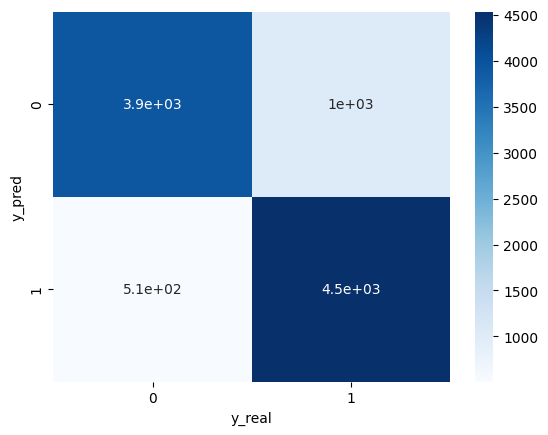

In [9]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

## Predicciones

In [10]:
X_conjunto_test = conjunto_test_processed.copy()
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>y_predic.flatten().mean(),1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index + 60000,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,positivo
3,60003,positivo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [11]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lematizacion_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lematizacion_{current_date}.csv", index=False)

# 5. Ensamble de 3 modelos (o mas)

## Importaciones

In [19]:
# Datasets a cargar
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

# Esos son los que fueron lematizados
X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']
conjunto_test_processed = pd.read_csv('Datasets/conjunto_test_processed.csv', index_col=0)['review_es']

## Voting

### Creacion del Ensamble

In [ ]:
# Tomando los ultimos y los mejores (que no es el ultimo) de cada modelo

ultimo_nb_model = joblib.load('Modelos/bn_model_2024-06-15.joblib')
mejor_nb_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

# Aca tenemos problemas con ese parametro cuando cargamos el modelo, asi ponemos True cada vez
if hasattr(ultimo_nb_model, 'force_alpha') and ultimo_nb_model.force_alpha not in [True, False]:
    ultimo_nb_model.force_alpha = True
if hasattr(mejor_nb_model, 'force_alpha') and mejor_nb_model.force_alpha not in [True, False]:
    mejor_nb_model.force_alpha = True

ultimo_xgb_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')
mejor_xgb_model = joblib.load('Modelos/xgb_model_2024-05-28.joblib')

ultimo_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')
mejor_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

In [16]:
# Utilizamos los F1-Score de Kaggle para ponderar los modelos
f1_scores = {
    'ultimo nb': 0.74588,
    'mejor nb': 0.74840,
    'ultimo xgb': 0.70304,
    'mejor xgb': 0.71215,
    'ultimo rf': 0.68773,
    'mejor rf': 0.68773,
}

# Normalizacion de los pesos
total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

# Creacion del ensamble
ensemble = VotingClassifier(estimators=[
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
], voting='soft', weights=initial_weights)  # 'soft' para probabilidades, 'hard' para mayorías

# Vectorizacion de los conjuntos
vect = TfidfVectorizer(stop_words=stop_words_es)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

# Ajustar el ensamble
ensemble.fit(X_train_vect, y_train)

KeyboardInterrupt: 

In [35]:
# Predicciones del ensamble
y_pred = ensemble.predict(X_test_vect)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

F1-Score: 0.8866686257224018


### Conjunto Test

In [36]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = ensemble.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [37]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_{current_date}.csv", index=False)

joblib.dump(ensemble, f'Modelos/Ensamble_voting_{current_date}.joblib')

['Modelos/Ensamble_voting_2024-06-15.joblib']

### Intentamos con redes neuronales unicamente

In [20]:
# Creacion de nuestro propio classifier para soportar las redes neuronales
class KerasVotingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1] * len(models)

    def fit(self, X_train, y_train, X_train_list, X_test, y_test):
        for model in self.models:
            # Debemos adaptar la capa de vectorizacion de nuevo
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_train_list)

            # Esos metodos de regularizacion nos permiten mejorar el modelo
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
            callbacks_list = [early_stopping, reduce_lr]

            model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=[F1Score])
            model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=callbacks_list)
    
    def predict(self, X, X_list=None):
        prediction_list = []
        for model in self.models :
            # Debemos adaptar la capa de vectorizacion de nuevo para predecir
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_list)
            prediction_list.append(model.predict(X))
        
        predictions = np.array(prediction_list)

        # Votacion por promedio
        avg_predictions = (np.average(predictions, axis=0, weights=self.weights) > 0.4).astype(int)
        
        return avg_predictions

In [22]:
# Modelos sin lematizacion
models = [
    load_model('Modelos/red_neuronal_2024-06-11.h5'),
    load_model('Modelos/red_neuronal_2024-06-14.h5'),
    load_model('Modelos/red_neuronal_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_2024-06-17.h5')
]

# Modelos con lematizacion
models_lemm = [
    load_model('Modelos/red_neuronal_lemmarizacion_1_dense_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_1_dense_2024-06-22.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_hiperparametros_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_recurrent_2024-06-23.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-25.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_2_dense_2024-06-24.h5')
]

In [23]:
# Transformacion en lista
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
X_train_lemm_list = X_train_processed.tolist()
X_test_lemm_list = X_test_processed.tolist()

# Transformacion en array
X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)
X_train_lemm_array = np.array(X_train_lemm_list, dtype=object).reshape(-1,1)
X_test_lemm_array = np.array(X_test_lemm_list, dtype=object).reshape(-1,1)

In [24]:
# Utilizamos los F1-Score de Kaggle para ponderar los modelos
f1_scores = {
    'keras1': 0.76584,
    'keras2': 0.75789,
    'keras3': 0.75770,
    'keras4': 0.75596
}

f1_scores_lemm = {
    'keras1': 0.77263,
    'keras2': 0.75751,
    'keras3': 0.76371,
    'keras4': 0.77863,
    'keras5': 0.74704,
    'keras6': 0.76235,
    'keras7': 0.75247,
    'keras8': 0.77127,
    'keras9': 0.76584,
    'keras10': 0.72669
}

# Normalizacion de los pesos
total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

total_f1_lemm = sum(f1_scores_lemm.values())
initial_weights_lemm = [score / total_f1_lemm for score in f1_scores_lemm.values()]

# Creacion del ensamble
voting_classifier = KerasVotingClassifier(models=models, weights=initial_weights)
voting_classifier.fit(X_train_array, y_train, X_train_list, X_test_array, y_test)

voting_classifier_lemm = KerasVotingClassifier(models=models_lemm, weights=initial_weights_lemm)
voting_classifier_lemm.fit(X_train_lemm_array, y_train, X_train_lemm_list, X_test_lemm_array, y_test)

# Predicciones del ensamble
y_pred_avg = voting_classifier.predict(X_test_array, X_train_list)
y_pred_avg_lemm = voting_classifier_lemm.predict(X_test_lemm_array, X_train_lemm_list)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_avg)
precision = precision_score(y_test, y_pred_avg)
recall = recall_score(y_test, y_pred_avg)
f1 = f1_score(y_test, y_pred_avg)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

accuracy_lemm = accuracy_score(y_test, y_pred_avg_lemm)
precision_lemm = precision_score(y_test, y_pred_avg_lemm)
recall_lemm = recall_score(y_test, y_pred_avg_lemm)
f1_lemm = f1_score(y_test, y_pred_avg_lemm)

print(f'Accuracy - Lematizacion: {accuracy_lemm}')
print(f'Precision - Lematizacion: {precision_lemm}')
print(f'Recall - Lematizacion: {recall_lemm}')
print(f'F1 Score - Lematizacion: {f1_lemm}')

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - f1_score: 0.6626 - loss: 0.6802 - val_f1_score: 0.6711 - val_loss: 0.7282 - learning_rate: 0.0050
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6670 - loss: 0.7440 - val_f1_score: 0.6720 - val_loss: 0.7852 - learning_rate: 0.0050
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6699 - loss: 0.7366 - val_f1_score: 0.6722 - val_loss: 0.8163 - learning_rate: 0.0050
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6663 - loss: 0.7515 - val_f1_score: 0.6712 - val_loss: 0.7615 - learning_rate: 0.0050
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6636 - loss: 0.5569 - val_f1_score: 0.6705 - val_loss: 0.4323 - learning_rate: 1.0000e-03
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.6672 - loss: 0.3645 - val_f1_score: 0.6703 - val_loss: 0.4088 - learning_rate: 1.0000e-03
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - f1_score: 0.

In [25]:
# Transformacion de los conjuntos de test
conjunto_test_index = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test_index['review_es']
X_conjunto_test_list = X_conjunto_test.tolist()

X_conjunto_test_lemm = conjunto_test_processed
X_conjunto_test_list_lemm = X_conjunto_test_lemm.tolist()

# Predicciones con y sin lematizacion
pred_test_avg = voting_classifier.predict(X_conjunto_test, X_conjunto_test_list)
pred_test_avg_lemm = voting_classifier_lemm.predict(X_conjunto_test_lemm, X_conjunto_test_list_lemm)

pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_avg]
pred_test_labels_lemm = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_avg_lemm]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df_lemm = pd.DataFrame({
    'ID': conjunto_test_processed.index,
    'sentimiento': pred_test_labels_lemm
})

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [26]:
# Exportacion del modelo y de las predicciones
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_redes_neuronales_{current_date}.csv", index=False)
final_pred_df_lemm.to_csv(f"Predicciones/Ensamble_voting_redes_neuronales_lematizacion_{current_date}.csv", index=False)

## Stacking

### Creacion del ensamble

In [ ]:
# Tomando los ultimos y los mejores (que no es el ultimo) de cada modelo

ultimo_nb_model = joblib.load('Modelos/bn_model_2024-06-15.joblib')
mejor_nb_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

# Aca tenemos problemas con ese parametro cuando cargamos el modelo, asi ponemos True cada vez
if hasattr(ultimo_nb_model, 'force_alpha') and ultimo_nb_model.force_alpha not in [True, False]:
    ultimo_nb_model.force_alpha = True
if hasattr(mejor_nb_model, 'force_alpha') and mejor_nb_model.force_alpha not in [True, False]:
    mejor_nb_model.force_alpha = True

ultimo_xgb_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')
mejor_xgb_model = joblib.load('Modelos/xgb_model_2024-05-28.joblib')

ultimo_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')
mejor_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

In [38]:
# Vectorizacion de los conjuntos
vect = TfidfVectorizer(stop_words=stop_words_es, min_df=2, ngram_range=(1,3))

X_train_vect = vect.fit_transform(X_train).astype('float32')
X_test_vect = vect.transform(X_test).astype('float32')

In [39]:
# Lista de nuestros modelos
base_models = [
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
]

base_predictions_train = np.zeros((X_train_vect.shape[0], len(base_models)))
base_predictions_test = np.zeros((X_test_vect.shape[0], len(base_models)))

# Por cada modelo, predecimos los resultados
for i, (name, model) in enumerate(base_models):
    model.fit(X_train_vect, y_train)
    base_predictions_train[:, i] = cross_val_predict(model, X_train_vect, y_train, cv=5, method='predict_proba')[:, 1]
    base_predictions_test[:, i] = model.predict_proba(X_test_vect)[:, 1]

# Meta-aprendizaje con LogisticRegression
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(base_predictions_train, y_train)

final_predictions = meta_learner.predict(base_predictions_test)

# Evaluación
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

F1-Score: 0.8994176290593229


### Conjunto test

In [40]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

base_predictions_conjunto_test = np.zeros((X_conjunto_test.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    base_predictions_conjunto_test[:, i] = model.predict_proba(X_conjunto_test)[:, 1]

pred_test = meta_learner.predict(base_predictions_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [41]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_{current_date}.csv", index=False)

joblib.dump(meta_learner, f'Modelos/Ensamble_stacking_{current_date}.joblib')

['Modelos/Ensamble_stacking_2024-06-16.joblib']

### Intentamos con redes neuronales

In [35]:
# Creacion de nuestro propio classifier para soportar las redes neuronales
class KerasStackingClassifier:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights is not None else [1] * len(models)

    def fit(self, X_train, y_train, X_train_list):
        # Meta-aprendizaje con LogisticRegression
        self.meta_learner = LogisticRegression(random_state=42)
        self.base_predictions_train = np.zeros((X_train.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            # Debemos adaptar la capa de vectorizacion de nuevo
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_train_list)
            self.base_predictions_train[:, i] = model.predict(X_train).flatten()

        # Optimizacion del LogisticRegression
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2']
        }
        grid_search = GridSearchCV(self.meta_learner, param_grid, cv=5, scoring='f1')
        grid_search.fit(self.base_predictions_train, y_train)
        
        self.meta_learner = grid_search.best_estimator_
        self.meta_learner.fit(self.base_predictions_train, y_train)

    def predict(self, X_test, X_test_list):
        base_predictions_test = np.zeros((X_test.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            # Debemos adaptar la capa de vectorizacion de nuevo
            text_vectorization_layer = model.layers[0]
            text_vectorization_layer.adapt(X_test_list)
            base_predictions_test[:, i] = model.predict(X_test).flatten()

        final_predictions = self.meta_learner.predict(base_predictions_test)
        return final_predictions

In [36]:
# Modelos sin lematizacion
models = [
    load_model('Modelos/red_neuronal_2024-06-11.h5'),
    load_model('Modelos/red_neuronal_2024-06-14.h5'),
    load_model('Modelos/red_neuronal_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_2024-06-17.h5')
]

# Modelos con lematizacion
models_lemm = [
    load_model('Modelos/red_neuronal_lemmarizacion_1_dense_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-15.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-17.h5')
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_1_dense_2024-06-22.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-17.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_dense_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_hiperparametros_2024-06-18.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_recurrent_2024-06-23.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_2024-06-25.h5'),
    load_model('Modelos/red_neuronal_lemmarizacion_dropout_2_dense_2024-06-24.h5')
]

# Transformacion en lista
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
X_train_lemm_list = X_train_processed.tolist()
X_test_lemm_list = X_test_processed.tolist()

# Transformacion en array
X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)
X_train_lemm_array = np.array(X_train_lemm_list, dtype=object).reshape(-1,1)
X_test_lemm_array = np.array(X_test_lemm_list, dtype=object).reshape(-1,1)

In [37]:
# Creacion del ensamble
stacking_classifier = KerasStackingClassifier(models=models)
stacking_classifier.fit(X_train_array, y_train, X_train_list)

stacking_classifier_lemm = KerasStackingClassifier(models=models_lemm)
stacking_classifier_lemm.fit(X_train_lemm_array, y_train, X_train_lemm_list)

# Predicciones del ensamble
final_predictions = stacking_classifier.predict(X_test_array, X_test_list)
final_predictions_lemm = stacking_classifier_lemm.predict(X_test_lemm_array, X_test_lemm_list)

# Evaluación
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

accuracy_lemm = accuracy_score(y_test, final_predictions_lemm)
precision_lemm = precision_score(y_test, final_predictions_lemm)
recall_lemm = recall_score(y_test, final_predictions_lemm)
f1_lemm = f1_score(y_test, final_predictions_lemm)

print(f'Accuracy - Lematizacion: {accuracy_lemm}')
print(f'Precision - Lematizacion: {precision_lemm}')
print(f'Recall - Lematizacion: {recall_lemm}')
print(f'F1 Score - Lematizacion: {f1_lemm}')

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step


c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\flaph\AppData\Local\Programs\Pyt

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
F1-Score: 0.8714159030446349
F1-Score - Lemm: 0.8756799525269509


In [38]:
# Transformacion de los conjuntos de test
conjunto_test_index = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test_index['review_es']
X_conjunto_test_list = X_conjunto_test.tolist()
X_conjunto_test_array = np.array(X_conjunto_test_list, dtype=object).reshape(-1, 1)

X_conjunto_test_lemm = conjunto_test_processed
X_conjunto_test_list_lemm = X_conjunto_test_lemm.tolist()
X_conjunto_test_array_lemm = np.array(X_conjunto_test_list_lemm, dtype=object).reshape(-1, 1)

# Predicciones con y sin lematizacion
pred_test = stacking_classifier.predict(X_conjunto_test_array, X_conjunto_test_list)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

pred_test_lemm = stacking_classifier_lemm.predict(X_conjunto_test_array_lemm, X_conjunto_test_list_lemm)
pred_test_labels_lemm = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemm]

# Transformacion en DataFrame para respetar las consignas
final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df_lemm = pd.DataFrame({
    'ID': conjunto_test_processed.index,
    'sentimiento': pred_test_labels_lemm
})

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [39]:
# Exportacion del modelo y de las predicciones
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_redes_neuronales_{current_date}.csv", index=False)
joblib.dump(stacking_classifier.meta_learner, f'Modelos/Ensamble_stacking_redes_neuronales_{current_date}.joblib')

final_pred_df_lemm.to_csv(f"Predicciones/Ensamble_stacking_redes_neuronales_lemmatizacion_{current_date}.csv", index=False)
joblib.dump(stacking_classifier_lemm.meta_learner, f'Modelos/Ensamble_stacking_redes_neuronales_lemmatizacion_{current_date}.joblib')

['Modelos/Ensamble_stacking_redes_neuronales_lemmatizacion_2024-06-24.joblib']